# Contact Classification

Download data from: https://utexas.box.com/s/5tvy96e01yett9kqdu5htdsvn9q6dtyc  
_Requires a UT account_  
Place the downloaded data in a folder `data/`

## Import statements

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re

## Parse data

### Read files

In [155]:
file_pattern = "*.csv"
data_path = os.fspath("data/oct30")
data_files = glob.glob(file_pattern, root_dir=data_path)

excluded_test_ids = {"lpf", "rpf"}

print(f"Found {len(data_files)} data files")
test_id_set = set()
for file_name in data_files:
    file_prefix = file_name.split("_")[0]
    test_id_set.add(file_prefix)
for test_id in test_id_set:
    if test_id in excluded_test_ids:
        print(f"Unique Test ID: {test_id} : Excluded from test sets")
    else:
        print(f"Unique Test ID: {test_id} : Included in test sets")


Found 25 data files
Unique Test ID: lpf : Excluded from test sets
Unique Test ID: lp1 : Included in test sets
Unique Test ID: rpf : Excluded from test sets
Unique Test ID: lp0 : Included in test sets
Unique Test ID: rp1 : Included in test sets
Unique Test ID: rp2 : Included in test sets
Unique Test ID: rp0 : Included in test sets
Unique Test ID: lp2 : Included in test sets


### Append data files to Pandas dataframe

In [156]:
df_list = []
for file_name in data_files:
    file_prefix = file_name.split("_")[0]
    file = os.path.join(data_path, file_name)
    temp_df = pd.read_csv(file)
    temp_df.insert(0,"test_id",file_prefix)
    df_list.append(temp_df)
data_raw = pd.concat(df_list)
display(data_raw)
display(data_raw.dtypes)

,test_id,Time (s.ms),Force_gauge (N),Linear_position (mm),strain_0.0800m (µε),strain_1.2841m (µε),strain_0.0800m (µε).1,strain_0.0807m (µε),strain_0.0813m (µε),strain_0.0820m (µε),...,strain_1.2799m (µε),strain_1.2806m (µε),strain_1.2812m (µε),strain_1.2818m (µε),strain_1.2825m (µε),strain_1.2831m (µε),strain_1.2838m (µε),strain_1.2845m (µε),strain_1.2851m (µε),strain_1.2858m (µε)
0,lp0,42.886,0.0,-1.074219,-12.9,-1.0,-12.9,3.400000,-6.800001,-8.500000,...,-2.500000,-11.499999,1.299999,1.9,-10.200001,-9.6,-2.5,-4.0,-1.900001,-1.0
1,lp0,43.171,0.0,-1.048584,-0.6,0.8,-0.6,-1.600000,-10.800001,3.900000,...,-2.500000,-16.899999,-11.600000,-5.8,-0.400002,-5.1,9.5,1.3,-14.900000,0.8
2,lp0,43.449,0.0,-1.021729,-10.3,-6.0,-10.3,12.100001,-2.000001,14.100000,...,5.700001,-15.999999,-20.200000,-11.6,-6.100000,-11.6,10.7,5.2,-8.300000,-6.0
3,lp0,43.766,0.0,-0.995361,-4.9,11.5,-4.9,-1.300000,-2.400001,8.100000,...,0.600000,-9.199999,-21.000000,1.1,-10.400001,-6.5,10.2,15.3,4.700000,11.5
4,lp0,44.062,0.0,-0.989502,-7.3,5.1,-7.3,1.800000,-6.800001,2.700000,...,0.200000,-6.900000,0.699999,-7.1,-5.300001,-9.6,-14.5,-6.7,-6.400000,5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,rpf,38.734,0.0,3.550781,-4.2,-6.9,-4.2,-5.900000,13.800000,18.199999,...,6.200000,1.000000,32.900002,11.7,-2.000000,-11.6,-2.9,1.9,-2.400000,-6.9
119,rpf,38.988,0.0,3.575928,0.0,-8.9,0.0,-6.900000,-7.600000,8.299999,...,10.099999,-12.100000,3.700000,-3.7,-7.400000,-10.8,6.1,1.4,-3.000000,-8.9
120,rpf,39.241,0.0,3.600586,3.1,-11.8,3.1,-1.900000,4.200000,-5.400000,...,-8.400000,-6.500001,5.700000,5.1,-7.100000,-23.3,-8.8,-10.5,-7.100000,-11.8
121,rpf,39.510,0.0,3.625000,-10.9,-7.4,-10.9,-10.000000,-1.500000,0.000000,...,-0.400001,7.199999,11.900000,16.6,-2.000000,-14.5,-9.8,-9.9,-16.200000,-7.4


test_id                  object
Time (s.ms)             float64
Force_gauge (N)         float64
Linear_position (mm)    float64
strain_0.0800m (µε)     float64
                         ...   
strain_1.2831m (µε)     float64
strain_1.2838m (µε)     float64
strain_1.2845m (µε)     float64
strain_1.2851m (µε)     float64
strain_1.2858m (µε)     float64
Length: 1862, dtype: object

### Remove extra gauges and sort by position along sensor

In [157]:
data = data_raw.loc[:, ~data_raw.columns.str.contains(r"\.\d+$")]

strain_cols = [col for col in data.columns if col.startswith("strain")]
other_cols = [col for col in data.columns if col not in strain_cols]

x_axis_raw = np.array([float(re.search(r"strain_(.*)m", x).group(1)) for x in strain_cols])
sorted_idx = np.argsort(x_axis_raw)
x_axis = np.sort(x_axis_raw)
sorted_strain_cols = [strain_cols[i] for i in sorted_idx]
data = data[other_cols + sorted_strain_cols]
display(data)

,test_id,Time (s.ms),Force_gauge (N),Linear_position (mm),strain_0.0800m (µε),strain_0.0807m (µε),strain_0.0813m (µε),strain_0.0820m (µε),strain_0.0826m (µε),strain_0.0833m (µε),...,strain_1.2806m (µε),strain_1.2812m (µε),strain_1.2818m (µε),strain_1.2825m (µε),strain_1.2831m (µε),strain_1.2838m (µε),strain_1.2841m (µε),strain_1.2845m (µε),strain_1.2851m (µε),strain_1.2858m (µε)
0,lp0,42.886,0.0,-1.074219,-12.9,3.400000,-6.800001,-8.500000,8.400001,4.300000,...,-11.499999,1.299999,1.9,-10.200001,-9.6,-2.5,-1.0,-4.0,-1.900001,-1.0
1,lp0,43.171,0.0,-1.048584,-0.6,-1.600000,-10.800001,3.900000,2.300000,2.500000,...,-16.899999,-11.600000,-5.8,-0.400002,-5.1,9.5,0.8,1.3,-14.900000,0.8
2,lp0,43.449,0.0,-1.021729,-10.3,12.100001,-2.000001,14.100000,9.200000,-8.400000,...,-15.999999,-20.200000,-11.6,-6.100000,-11.6,10.7,-6.0,5.2,-8.300000,-6.0
3,lp0,43.766,0.0,-0.995361,-4.9,-1.300000,-2.400001,8.100000,12.099999,-12.600000,...,-9.199999,-21.000000,1.1,-10.400001,-6.5,10.2,11.5,15.3,4.700000,11.5
4,lp0,44.062,0.0,-0.989502,-7.3,1.800000,-6.800001,2.700000,17.400001,3.600000,...,-6.900000,0.699999,-7.1,-5.300001,-9.6,-14.5,5.1,-6.7,-6.400000,5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,rpf,38.734,0.0,3.550781,-4.2,-5.900000,13.800000,18.199999,15.699999,-2.700000,...,1.000000,32.900002,11.7,-2.000000,-11.6,-2.9,-6.9,1.9,-2.400000,-6.9
119,rpf,38.988,0.0,3.575928,0.0,-6.900000,-7.600000,8.299999,15.199999,8.500000,...,-12.100000,3.700000,-3.7,-7.400000,-10.8,6.1,-8.9,1.4,-3.000000,-8.9
120,rpf,39.241,0.0,3.600586,3.1,-1.900000,4.200000,-5.400000,2.400000,3.700001,...,-6.500001,5.700000,5.1,-7.100000,-23.3,-8.8,-11.8,-10.5,-7.100000,-11.8
121,rpf,39.510,0.0,3.625000,-10.9,-10.000000,-1.500000,0.000000,4.299999,0.100000,...,7.199999,11.900000,16.6,-2.000000,-14.5,-9.8,-7.4,-9.9,-16.200000,-7.4


## Data Processing

### Visualize strain ranges

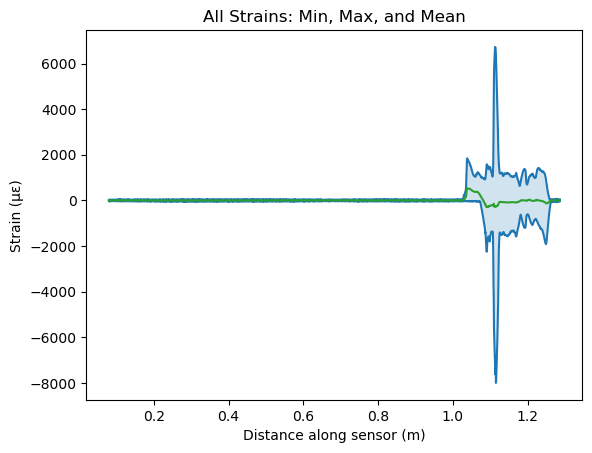

In [158]:
upper_bound = data[sorted_strain_cols].max()
lower_bound = data[sorted_strain_cols].min()
mean_line = data[sorted_strain_cols].mean()

fig, ax = plt.subplots()
ax.plot(x_axis,upper_bound,color='tab:blue')
ax.plot(x_axis,lower_bound,color='tab:blue')
ax.plot(x_axis,mean_line,color='tab:green')
ax.fill_between(x_axis,upper_bound,lower_bound,alpha=0.2)
ax.set_title("All Strains: Min, Max, and Mean")
ax.set_ylabel("Strain (με)")
ax.set_xlabel("Distance along sensor (m)")
plt.show()

### Cutoff excess early data

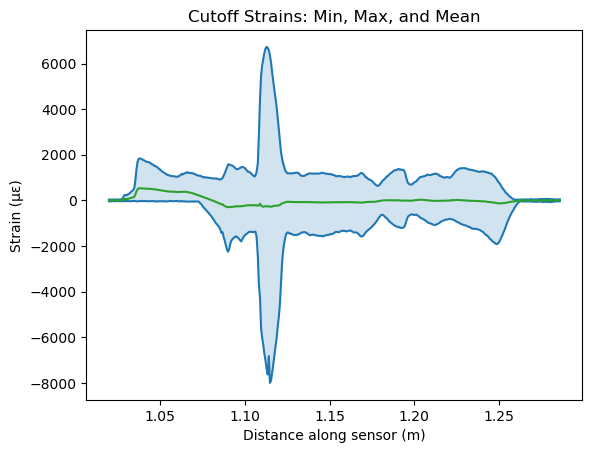

In [159]:
start_location = 1.02
cutoff_idx = (np.abs(x_axis - start_location)).argmin()
cutoff_strain = data[sorted_strain_cols].iloc[:,cutoff_idx:]
cutoff_x_axis = x_axis[cutoff_idx:]

upper_bound = cutoff_strain.max()
lower_bound = cutoff_strain.min()
mean_line = cutoff_strain.mean()

fig, ax = plt.subplots()
ax.plot(cutoff_x_axis,upper_bound,color='tab:blue')
ax.plot(cutoff_x_axis,lower_bound,color='tab:blue')
ax.plot(cutoff_x_axis,mean_line,color='tab:green')
ax.fill_between(cutoff_x_axis,upper_bound,lower_bound,alpha=0.2)
ax.set_title("Cutoff Strains: Min, Max, and Mean")
ax.set_ylabel("Strain (με)")
ax.set_xlabel("Distance along sensor (m)")
plt.show()

In [160]:
cutoff_strain.head(10)

,strain_1.0199m (µε),strain_1.0206m (µε),strain_1.0212m (µε),strain_1.0218m (µε),strain_1.0225m (µε),strain_1.0231m (µε),strain_1.0238m (µε),strain_1.0244m (µε),strain_1.0251m (µε),strain_1.0258m (µε),...,strain_1.2806m (µε),strain_1.2812m (µε),strain_1.2818m (µε),strain_1.2825m (µε),strain_1.2831m (µε),strain_1.2838m (µε),strain_1.2841m (µε),strain_1.2845m (µε),strain_1.2851m (µε),strain_1.2858m (µε)
0,9.399999,-5.700000,2.8,-3.300000,-14.600000,3.499999,9.000000,20.499999,0.100000,-8.600000,...,-11.499999,1.299999,1.9,-10.200001,-9.600000,-2.5,-1.0,-4.0,-1.900001,-1.0
1,21.600000,9.500000,-8.3,-2.100000,-5.200000,-2.800000,-4.500000,28.900001,3.800000,-0.700000,...,-16.899999,-11.600000,-5.8,-0.400002,-5.100000,9.5,0.8,1.3,-14.900000,0.8
2,1.000000,5.100000,4.9,14.300000,-0.300000,-3.500000,-3.300000,11.500000,10.200001,2.000000,...,-15.999999,-20.200000,-11.6,-6.100000,-11.600000,10.7,-6.0,5.2,-8.300000,-6.0
3,0.800000,12.900000,22.9,31.699999,7.200000,-8.900000,0.400000,19.400000,7.500000,0.900001,...,-9.199999,-21.000000,1.1,-10.400001,-6.500000,10.2,11.5,15.3,4.700000,11.5
4,-0.100000,-8.200000,-4.3,17.100000,10.599999,17.799998,5.000000,17.900000,0.400000,9.100000,...,-6.900000,0.699999,-7.1,-5.300001,-9.600000,-14.5,5.1,-6.7,-6.400000,5.1
5,21.399999,11.000000,6.1,21.900000,15.700000,10.099999,-7.200001,10.100000,0.200000,4.200001,...,-14.699999,-21.600000,-21.7,-7.000001,-8.600000,6.9,-0.2,-10.5,-7.100000,-0.2
6,9.500000,11.000000,11.4,5.100000,-1.900001,4.099999,7.000000,26.499999,6.700000,4.900000,...,-6.199999,-1.500000,-2.0,-9.800001,-4.700000,16.1,-8.1,1.6,-14.300000,-8.1
7,-3.700000,-3.600000,11.9,30.199999,-3.200000,-3.600000,1.600000,23.800000,-4.200000,2.900001,...,-11.900000,-19.700000,-11.1,-6.900001,-16.600000,10.9,-4.9,-8.7,-5.000000,-4.9
8,8.899999,21.200001,14.9,19.500000,-8.300000,-0.200000,-1.200001,7.900000,-14.700000,-13.400000,...,3.800001,-14.700000,-14.6,-5.800001,5.999999,5.5,-7.8,2.5,-6.400000,-7.8
9,3.400000,2.100000,5.7,17.600000,12.099999,11.400001,-0.700001,17.099999,-1.600000,-2.799999,...,-11.799999,-24.800000,-18.2,-7.000001,-14.700000,12.1,-7.8,3.8,-5.200000,-7.8


### Remove NAN values

In [161]:
display(cutoff_strain.isna().sum().sum())
cutoff_strain.interpolate(axis=0, inplace=True)
cutoff_strain.interpolate(axis=1, inplace=True)
display(cutoff_strain.isna().sum().sum())


3775

0

### Create classification labels

In [162]:
force_threshold = 0.01
contact_data = pd.DataFrame({"Contact": (data['Force_gauge (N)'] >= force_threshold).astype(int)})
contact_data["Contact"].value_counts()

Contact
0    2070
1     566
Name: count, dtype: int64

## Train Model

### Create custom cross-validation splits

In [163]:
cv_split_array = np.zeros(len(data.test_id))
test_id_array = data.test_id.to_numpy()
i = 0
for test_id in test_id_set:
    if test_id in excluded_test_ids:
        split_idx = -1
    else:
        split_idx = i
        i += 1
    cv_split_array = np.where(test_id_array == test_id, split_idx, cv_split_array)
print(f"Generated {i} test sets")

Generated 6 test sets


### Train Classification Model

In [164]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import PredefinedSplit

model = GradientBoostingClassifier()
folds = PredefinedSplit(cv_split_array)

scores = cross_validate(model, cutoff_strain, contact_data.to_numpy().squeeze(), 
                        cv=folds, 
                        scoring=['precision','recall'], 
                        return_train_score=True,
                        n_jobs = -1)

In [165]:
display(pd.DataFrame(scores))

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall
0,16.134362,0.003499,0.867925,1.0,0.582278,1.0
1,17.132027,0.003001,1.000000,1.0,0.813433,1.0
2,16.692043,0.002999,1.000000,1.0,0.064516,1.0
3,17.184624,0.003000,1.000000,1.0,0.631579,1.0
4,17.037916,0.003504,1.000000,1.0,0.510417,1.0
5,16.853686,0.003504,1.000000,1.0,0.790123,1.0


In [174]:
# Reduce overfitting with regularization parameters
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

regularized_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.6,
    max_depth=3,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=1,
    max_features=0.3,
    random_state=42
)

regularized_scores = cross_validate(
    regularized_model, cutoff_strain, contact_data.to_numpy().squeeze(), 
    cv=folds, 
    scoring=['precision','recall'], 
    return_train_score=True,
    n_jobs=-1
)



display(pd.DataFrame(regularized_scores))


,fit_time,score_time,test_precision,train_precision,test_recall,train_recall
0,4.917448,0.003000,0.939394,1.0,0.392405,1.0
1,5.148518,0.003002,1.000000,1.0,0.828358,1.0
2,5.089637,0.003005,0.857143,1.0,0.096774,1.0
3,5.333431,0.003001,1.000000,1.0,0.605263,1.0
4,5.106157,0.003000,1.000000,1.0,0.437500,1.0
5,5.149519,0.003005,1.000000,1.0,0.728395,1.0


### Dimensionality Reduction

In [171]:
# Strategy 2: Feature selection to reduce dimensionality
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

print(f"Original number of features: {cutoff_strain.shape[1]}")

feature_counts = [10, 20, 30, 50, 100, 200]
feature_results = {}

for k in feature_counts:
    print(f"\nTesting with top {k} features...")
    
    # Create pipeline with feature selection
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_classif, k=k)),
        ('classifier', GradientBoostingClassifier(
            n_estimators=50,
            learning_rate=0.1,
            max_depth=3,
            min_samples_split=20,
            min_samples_leaf=10,
            subsample=0.8,
            random_state=42
        ))
    ])
    
    
    scores = cross_validate(
        pipeline, cutoff_strain, contact_data.to_numpy().squeeze(),
        cv=folds,
        scoring=['precision', 'recall'],
        return_train_score=True,
        n_jobs=-1
    )
    
    display(pd.DataFrame(scores))
    
    # Calculate statistics
    train_precision_mean = scores['train_precision'].mean()
    test_precision_mean = scores['test_precision'].mean()
    train_recall_mean = scores['train_recall'].mean()
    test_recall_mean = scores['test_recall'].mean()
    
    precision_gap = train_precision_mean - test_precision_mean
    recall_gap = train_recall_mean - test_recall_mean
    
    feature_results[k] = {
        'train_precision': train_precision_mean,
        'test_precision': test_precision_mean,
        'train_recall': train_recall_mean,
        'test_recall': test_recall_mean,
        'precision_gap': precision_gap,
        'recall_gap': recall_gap
    }

print("feature selection comparison")
feature_selection_df = pd.DataFrame.from_dict(feature_results, orient='index')
feature_selection_df.index.name = 'Features'
display(feature_selection_df)

Original number of features: 411

Testing with top 10 features...


,fit_time,score_time,test_precision,train_precision,test_recall,train_recall
0,0.218325,0.003000,0.469880,0.857143,0.493671,0.517454
1,0.210811,0.004001,1.000000,0.926316,0.179104,0.407407
2,0.223824,0.003508,0.396552,0.872549,0.370968,0.529762
3,0.208310,0.003001,1.000000,0.893536,0.236842,0.519912
4,0.220821,0.003000,0.941176,0.940171,0.500000,0.468085
5,0.223824,0.003508,0.909091,0.906504,0.123457,0.459794



Testing with top 20 features...


,fit_time,score_time,test_precision,train_precision,test_recall,train_recall
0,0.345492,0.003004,0.774194,0.902516,0.607595,0.589322
1,0.372028,0.003000,1.000000,0.966981,0.253731,0.474537
2,0.351498,0.003000,0.343284,0.922438,0.370968,0.660714
3,0.363010,0.003003,1.000000,0.880702,0.350877,0.555310
4,0.354499,0.003011,0.905660,0.928302,0.500000,0.523404
5,0.353999,0.003008,1.000000,0.931159,0.246914,0.529897



Testing with top 30 features...


,fit_time,score_time,test_precision,train_precision,test_recall,train_recall
0,0.497683,0.003000,0.920000,0.938710,0.582278,0.597536
1,0.512701,0.003002,1.000000,0.948413,0.305970,0.553241
2,0.525708,0.003000,0.229730,0.943503,0.274194,0.662698
3,0.524708,0.003000,1.000000,0.917857,0.315789,0.568584
4,0.510695,0.003505,0.881356,0.925795,0.541667,0.557447
5,0.513701,0.003001,1.000000,0.940559,0.271605,0.554639



Testing with top 50 features...


,fit_time,score_time,test_precision,train_precision,test_recall,train_recall
0,0.790010,0.003500,0.931818,0.932308,0.518987,0.622177
1,0.823060,0.002997,1.000000,0.961977,0.350746,0.585648
2,0.805521,0.003007,0.202899,0.965241,0.225806,0.716270
3,0.827057,0.003020,1.000000,0.927336,0.456140,0.592920
4,0.838076,0.003513,0.838710,0.948949,0.541667,0.672340
5,0.815534,0.003013,1.000000,0.905013,0.382716,0.707216



Testing with top 100 features...


,fit_time,score_time,test_precision,train_precision,test_recall,train_recall
0,1.560014,0.004007,1.0,0.997854,0.645570,0.954825
1,1.663640,0.003500,1.0,1.000000,0.686567,0.932870
2,1.623096,0.003501,0.0,1.000000,0.000000,0.958333
3,1.684177,0.003000,1.0,1.000000,0.403509,0.953540
4,1.673653,0.003001,1.0,1.000000,0.489583,0.921277
5,1.658630,0.003004,1.0,1.000000,0.691358,0.950515



Testing with top 200 features...


,fit_time,score_time,test_precision,train_precision,test_recall,train_recall
0,3.106626,0.003500,1.0,1.0,0.658228,0.969199
1,3.282336,0.003506,1.0,1.0,0.791045,0.965278
2,3.210250,0.003000,1.0,1.0,0.016129,0.970238
3,3.322886,0.003510,1.0,1.0,0.535088,0.960177
4,3.320375,0.003012,1.0,1.0,0.572917,0.957447
5,3.271320,0.003000,1.0,1.0,0.666667,0.962887


feature selection comparison


,train_precision,test_precision,train_recall,test_recall,precision_gap,recall_gap
Features,,,,,,
10,0.899370,0.786116,0.483736,0.317340,0.113253,0.166395
20,0.922016,0.837190,0.555531,0.388347,0.084827,0.167183
30,0.935806,0.838514,0.582358,0.381917,0.097292,0.200440
50,0.940137,0.828904,0.649429,0.412677,0.111233,0.236751
100,0.999642,0.833333,0.945227,0.486098,0.166309,0.459129
200,1.000000,1.000000,0.964204,0.540012,0.000000,0.424192


### Strategy 3: Try Simpler Models

In [168]:
# Strategy 3: Compare simpler models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = {
    'Logistic Regression (L2)': LogisticRegression(C=1.0, random_state=42, max_iter=1000),
    'Logistic Regression (L1)': LogisticRegression(C=1.0, penalty='l1', solver='liblinear', random_state=42),
    'Random Forest (Small)': RandomForestClassifier(n_estimators=10, max_depth=3, min_samples_split=20, 
                                                   min_samples_leaf=10, random_state=42),
    'Random Forest (Medium)': RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_split=10, 
                                                    min_samples_leaf=5, random_state=42),
    'SVM (RBF)': SVC(C=1.0, gamma='scale', random_state=42)
}

model_results = {}

feature_selector = SelectKBest(score_func=f_classif, k=20)
X_selected = feature_selector.fit_transform(cutoff_strain, contact_data.to_numpy().squeeze())

for model_name, model in models.items():
    print(f"\nTesting {model_name}...")
    
    scores = cross_validate(
        model, X_selected, contact_data.to_numpy().squeeze(),
        cv=folds,
        scoring=['precision', 'recall'],
        return_train_score=True,
        n_jobs=-1
    )
    
    display(pd.DataFrame(scores))
    
    train_precision = scores['train_precision'].mean()
    test_precision = scores['test_precision'].mean()
    train_recall = scores['train_recall'].mean()
    test_recall = scores['test_recall'].mean()
    
    precision_gap = train_precision - test_precision
    recall_gap = train_recall - test_recall
    
    model_results[model_name] = {
        'Train_Precision': train_precision,
        'Test_Precision': test_precision,
        'Train_Recall': train_recall,
        'Test_Recall': test_recall,
        'Precision_Gap': precision_gap,
        'Recall_Gap': recall_gap,
        'Total_Gap': precision_gap + recall_gap
    }
    
print("Model comparison")
model_comparison_df = pd.DataFrame.from_dict(model_results, orient='index')
model_comparison_df = model_comparison_df.round(4)
display(model_comparison_df)


Testing Logistic Regression (L2)...


,fit_time,score_time,test_precision,train_precision,test_recall,train_recall
0,0.044595,0.001500,0.658228,0.659517,0.658228,0.505133
1,0.078158,0.001501,1.000000,0.669841,0.223881,0.488426
2,0.063653,0.001501,0.445455,0.692308,0.790323,0.535714
3,0.074658,0.001499,1.000000,0.649852,0.307018,0.484513
4,0.060130,0.002023,0.973684,0.668493,0.385417,0.519149
5,0.075656,0.001499,0.875000,0.686528,0.086420,0.546392



Testing Logistic Regression (L1)...


,fit_time,score_time,test_precision,train_precision,test_recall,train_recall
0,1.009746,0.001501,0.666667,0.663102,0.632911,0.509240
1,1.635160,0.001500,1.000000,0.669841,0.216418,0.488426
2,0.964194,0.002007,0.449541,0.702350,0.790323,0.533730
3,1.453902,0.001500,1.000000,0.647929,0.298246,0.484513
4,1.677208,0.001503,0.975000,0.671348,0.406250,0.508511
5,1.713269,0.002003,1.000000,0.690104,0.086420,0.546392



Testing Random Forest (Small)...


,fit_time,score_time,test_precision,train_precision,test_recall,train_recall
0,0.019029,0.001513,0.524752,0.641935,0.670886,0.408624
1,0.017529,0.000997,1.000000,0.954955,0.149254,0.245370
2,0.017527,0.001505,0.478261,0.758007,0.354839,0.422619
3,0.017528,0.001513,1.000000,0.944444,0.096491,0.263274
4,0.016529,0.001505,1.000000,0.801471,0.364583,0.231915
5,0.017532,0.002007,1.000000,0.935714,0.049383,0.270103



Testing Random Forest (Medium)...


,fit_time,score_time,test_precision,train_precision,test_recall,train_recall
0,0.106149,0.002500,0.745763,0.852740,0.556962,0.511294
1,0.111154,0.003002,1.000000,0.946809,0.231343,0.412037
2,0.107141,0.002000,0.333333,0.937294,0.338710,0.563492
3,0.111648,0.003009,1.000000,0.935000,0.157895,0.413717
4,0.105142,0.002499,1.000000,0.965986,0.416667,0.302128
5,0.120166,0.002501,1.000000,0.918803,0.234568,0.443299



Testing SVM (RBF)...


,fit_time,score_time,test_precision,train_precision,test_recall,train_recall
0,0.041048,0.016525,0.662162,0.625954,0.620253,0.336756
1,0.040045,0.010519,1.000000,0.781250,0.179104,0.231481
2,0.043055,0.017022,0.536585,0.696498,0.354839,0.355159
3,0.043551,0.009511,1.000000,0.794702,0.026316,0.265487
4,0.044551,0.010513,1.000000,0.754098,0.302083,0.195745
5,0.042552,0.012512,1.000000,0.739362,0.123457,0.286598


Model comparison


,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Precision_Gap,Recall_Gap,Total_Gap
Logistic Regression (L2),0.6711,0.8254,0.5132,0.4085,-0.1543,0.1047,-0.0496
Logistic Regression (L1),0.6741,0.8485,0.5118,0.4051,-0.1744,0.1067,-0.0677
Random Forest (Small),0.8394,0.8338,0.3070,0.2809,0.0056,0.0261,0.0317
Random Forest (Medium),0.9261,0.8465,0.4410,0.3227,0.0796,0.1183,0.1979
SVM (RBF),0.7320,0.8665,0.2785,0.2677,-0.1345,0.0109,-0.1236


In [169]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold

regressor = GradientBoostingRegressor()
y_force = data['Force_gauge (N)']
y_force.fillna(0, inplace=True)
scores = cross_validate(regressor, cutoff_strain, y_force, 
                        cv=folds, scoring=['neg_mean_absolute_error','r2'], n_jobs = -1)

print("MAE scores:", -scores['test_neg_mean_absolute_error'])
print("R2 scores:", scores['test_r2'])

MAE scores: [0.00730671 0.01249918 0.00773706 0.02499025 0.00784163 0.01172717]
R2 scores: [0.88432964 0.80838556 0.80453918 0.19786289 0.90891113 0.70624443]
